In [1]:
from collections import Counter
import matplotlib.pyplot as plt

# 1. Path to BED file
bed_path = "data/query.bed/query.bed"

# 2. Initialize a counter for fragment lengths
length_counts = Counter()

# 3. Read through the file and compute lengths
with open(bed_path) as f:
    for line in f:
        if line.startswith(("#", "track", "browser")):
            continue  # skip headers or comments
        cols = line.rstrip("\n").split("\t")
        start = int(cols[1])
        end   = int(cols[2])
        length = end - start
        if length > 0:
            length_counts[length] += 1


In [2]:
# Total number of fragments
total_frags = sum(length_counts.values())

# Create lists sorted by fragment length
lengths = sorted(length_counts)
raw_counts = [length_counts[L] for L in lengths]

# Normalize: divide each count by total
norm_freqs = [cnt / total_frags for cnt in raw_counts]


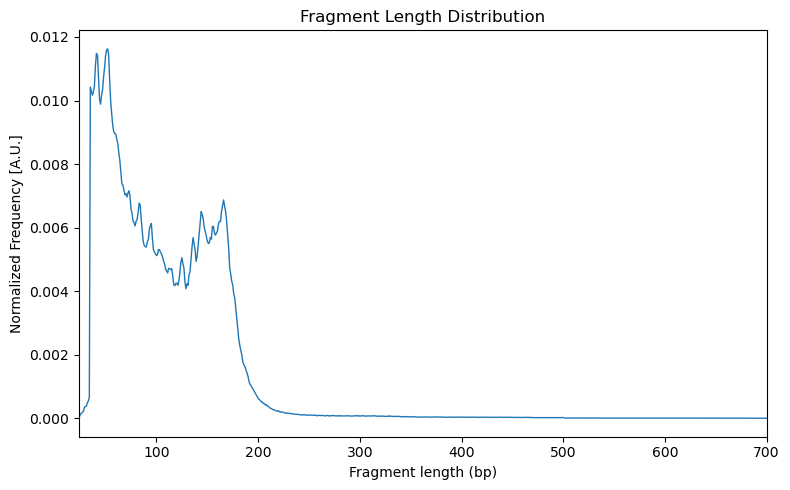

In [3]:
plt.figure(figsize=(8, 5))
plt.plot(lengths, norm_freqs, lw=1)
plt.xlabel("Fragment length (bp)")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution")
plt.xlim(min(lengths), max(lengths))
plt.tight_layout()
plt.show()


In [8]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Read and store query fragments
query_fragment_lengths = []
query_records = []

with open("data/query.bed/query.bed", "r") as query_file:
    for line in query_file:
        columns = line.strip().split()
        if len(columns) < 3:
            continue
        try:
            start = int(columns[1])
            end = int(columns[2])
            length = end - start
            if length > 0:
                query_fragment_lengths.append(length)
                query_records.append(line)
        except ValueError:
            continue

In [9]:
# Read and normalize reference histogram
reference_distribution = {}
with open("data/reference.hist", "r") as ref_file:
    for line in ref_file:
        parts = line.strip().split()
        if len(parts) >= 2:
            length = int(parts[0])
            frequency = float(parts[1])
            reference_distribution[length] = frequency

total_reference = sum(reference_distribution.values())
normalized_reference = {length: freq / total_reference for length, freq in reference_distribution.items()}

# Group query fragment indices by length
length_to_indices = defaultdict(list)
for index, length in enumerate(query_fragment_lengths):
    length_to_indices[length].append(index)

# Rescale query to match reference distribution
total_query_fragments = len(query_fragment_lengths)
rescaled_indices = []

In [10]:

for length, ref_prob in normalized_reference.items():
    target_count = int(ref_prob * total_query_fragments)
    available_indices = length_to_indices.get(length, [])
    sampled_indices = random.sample(available_indices, min(target_count, len(available_indices)))
    rescaled_indices.extend(sampled_indices)

rescaled_fragment_lengths = [query_fragment_lengths[i] for i in rescaled_indices]

# Frequency distributions for plotting
# Original query
original_count_map = defaultdict(int)
for length in query_fragment_lengths:
    original_count_map[length] += 1

original_total = len(query_fragment_lengths)
original_lengths = sorted(original_count_map)
original_frequencies = [original_count_map[l] / original_total for l in original_lengths]

# Reference
reference_lengths = sorted(normalized_reference)
reference_frequencies = [normalized_reference[l] for l in reference_lengths]

# Rescaled query
rescaled_count_map = defaultdict(int)
for length in rescaled_fragment_lengths:
    rescaled_count_map[length] += 1

rescaled_total = len(rescaled_fragment_lengths)
rescaled_lengths = sorted(rescaled_count_map)
rescaled_frequencies = [rescaled_count_map[l] / rescaled_total for l in rescaled_lengths]


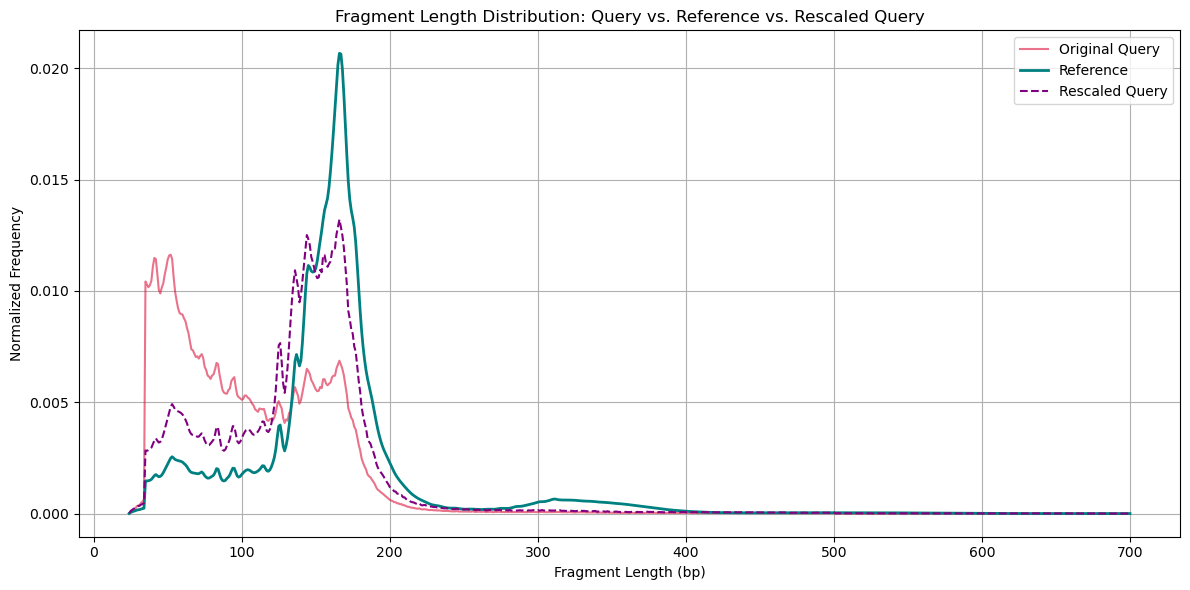

In [11]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(original_lengths, original_frequencies, label="Original Query", color='crimson', alpha=0.6)
plt.plot(reference_lengths, reference_frequencies, label="Reference", color='teal', linewidth=2)
plt.plot(rescaled_lengths, rescaled_frequencies, label="Rescaled Query", color='purple', linestyle='--')

plt.xlabel("Fragment Length (bp)")
plt.ylabel("Normalized Frequency")
plt.title("Fragment Length Distribution: Query vs. Reference vs. Rescaled Query")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()